### Misc Notes: 
- All images for color_labels, images, labels 1280x720
- Currently trying 128 resize with padding to 128x128
    - Initially had padding as white but then realized that could conflict with labels so changed all to skyblue
### Todo:
- Images not lining up with masks confirmed. FIX

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

from pathlib import Path
import json

/home/ray/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
torch.cuda.set_device(0)

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
PATH = Path('/home/ray/BDD/bdd100k/seg2_128')
os.listdir(PATH)

['color_labels',
 'tmp',
 'images',
 'train-128',
 'labels',
 'models',
 'train_masks-128']

In [7]:
sz = 128
bs = 64
nw = 16

aug_tfms = []

In [8]:
TRAIN = Path('{}/images/train'.format(PATH))
trn = glob(os.path.join(TRAIN, "*.jpg"))

TRAIN_MASKS = Path('{}/color_labels/train'.format(PATH))
trn_msk = glob(os.path.join(TRAIN_MASKS, "*.png"))

VALID = Path('{}/images/val'.format(PATH))
vld = glob(os.path.join(TRAIN, "*.jpg"))

VALID_MASKS = Path('{}/color_labels/val'.format(PATH))
vld_msk = glob(os.path.join(TRAIN_MASKS, "*.png"))

In [9]:
# TEST PATHS
# os.listdir(PATH)
# os.listdir(TRAIN)
# os.listdir(TRAIN_MASKS)
# os.listdir(VALID)
# os.listdir(VALID_MASKS)

# Data analyzing. Looking at small sample of images, resolution, planning ways to prep data

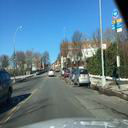

In [10]:
TEST_SINGLE_ID = '47406c52-6f9c5dbf'
Image.open(PATH/TRAIN/f'{TEST_SINGLE_ID}.jpg')

In [11]:
TRAIN_IDS = [str(TRAIN).split('/')[-1] for TRAIN in list((PATH/TRAIN).iterdir())]
TRAIN_MASK_IDS = [str(TRAIN_MASKS).split('/')[-1] for TRAIN_MASKS in list((PATH/TRAIN_MASKS).iterdir())]

In [12]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [13]:
# ims = [open_image(PATH/TRAIN/f'{SINGLE_ID}') for SINGLE_ID in TRAIN_IDS[:16]]
# im_masks = [open_image(PATH/TRAIN_MASKS/f'{SINGLE_ID}') for SINGLE_ID in TRAIN_MASK_IDS[:16]]

ims = [open_image(PATH/TRAIN/f'{SINGLE_ID}') for SINGLE_ID in TRAIN_IDS[:16]]
im_masks = [open_image(PATH/TRAIN_MASKS/f'{SINGLE_ID}') for SINGLE_ID in TRAIN_MASK_IDS[:16]]

# ims = sorted(glob.glob(os.path.join(TRAIN, "*.jpg")))
# im_masks = sorted(glob.glob(os.path.join(TRAIN_MASKS, "*.png")))

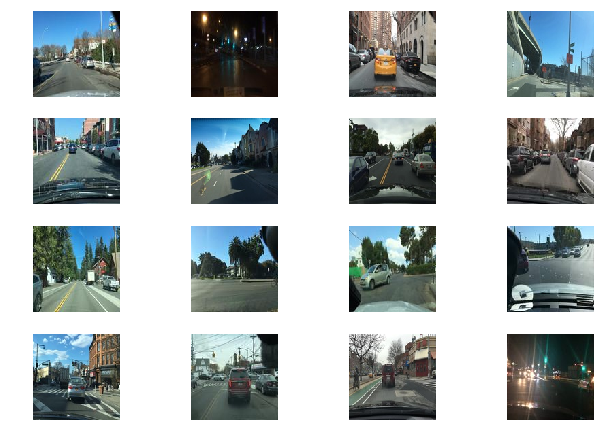

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

# Note to self: seems to be a lot of streets from small sample of 16.
# TODO: Figure out how to handle edge cases of night segmentation
# ???: Will reflection on windshield cause errors? Should sky be cropped as well? Reference 21:9 dash cams
# TOLEARN: Better to squash images to 1:1 aspect ratio as beginning will be trained with resnet? Or make image with padding?
# ie 1280x1280 with rest of height being padding

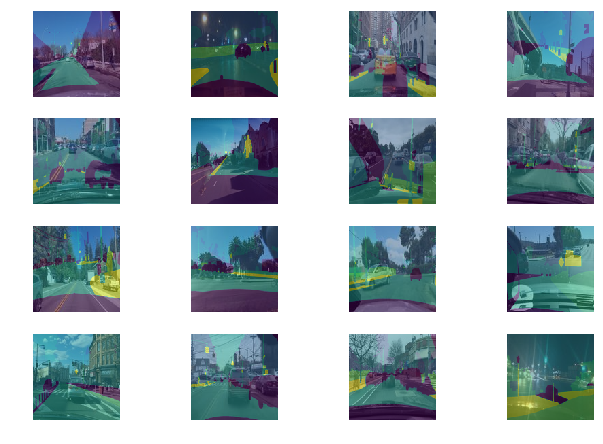

In [15]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

# print("ims:",ims)
# print("im_masks:",im_masks)

In [16]:
from PIL import Image
import os.path

filename = os.path.join(PATH/TRAIN)
# img_to_plot = Image.open(filename)
for SINGLE_ID in TRAIN_IDS[:16]:
    img_to_plot = Image.open(PATH/TRAIN/f'{SINGLE_ID}')
    width, height = img_to_plot.size
    print("SINGLE_ID:", SINGLE_ID, "Dimensions:", img_to_plot.size)
    
for SINGLE_ID in TRAIN_MASK_IDS[:16]:
    img_to_plot = Image.open(PATH/TRAIN_MASKS/f'{SINGLE_ID}')
    width, height = img_to_plot.size
    print("SINGLE_MASK_ID:", SINGLE_ID, "Dimensions:", img_to_plot.size)

SINGLE_ID: 47406c52-6f9c5dbf.jpg Dimensions: (128, 128)
SINGLE_ID: b674bc13-3e309d54.jpg Dimensions: (128, 128)
SINGLE_ID: 444450f8-eb43d2b7.jpg Dimensions: (128, 128)
SINGLE_ID: 0378d8dc-62d8851d.jpg Dimensions: (128, 128)
SINGLE_ID: 3f291ac3-d2abcdbd.jpg Dimensions: (128, 128)
SINGLE_ID: 4fc15031-9165c3f3.jpg Dimensions: (128, 128)
SINGLE_ID: 0c7aa2a6-9c0f3111.jpg Dimensions: (128, 128)
SINGLE_ID: bd46953e-1bb2f914.jpg Dimensions: (128, 128)
SINGLE_ID: 49c6e2f0-00000000.jpg Dimensions: (128, 128)
SINGLE_ID: 08cc3547-a9930000.jpg Dimensions: (128, 128)
SINGLE_ID: 9e771b2e-2d041638.jpg Dimensions: (128, 128)
SINGLE_ID: 96fc479b-ff3929ea.jpg Dimensions: (128, 128)
SINGLE_ID: 6db48fb9-5aeece40.jpg Dimensions: (128, 128)
SINGLE_ID: 614fd0a8-9891cb51.jpg Dimensions: (128, 128)
SINGLE_ID: 4c091ad8-6ea5f0d1.jpg Dimensions: (128, 128)
SINGLE_ID: 700c3115-5b5b7652.jpg Dimensions: (128, 128)
SINGLE_MASK_ID: 3f8b781f-38cbe876_train_color.png Dimensions: (128, 128)
SINGLE_MASK_ID: 7a0ba545-3961a9

In [17]:
# NOTE: Disabled for speed when restarting kernel. All 10k+ images in original training set are set to dimensions stated at top


# import matplotlib.pyplot as plt

# for SINGLE_ID in TRAIN_IDS:
#     img_to_plot = Image.open(PATH/TRAIN/f'{SINGLE_ID}')
#     width, height = img_to_plot.size
#     plt.plot([width], [height], 'ro')

# plt.xlabel('Width')
# plt.ylabel('Height')
# plt.show()

# Data Prep

In [18]:
# TODO: shrink to squished 128x128 instead of skyblue border
# FOR REFERENCE: 
# PATH = Path('/home/ray/BDD/bdd100k/seg')
# TRAIN = Path('{}/images/train'.format(PATH))
# TRAIN_MASKS = Path('{}/labels/train'.format(PATH))

In [19]:
img_x = Image.open(trn[0])
print("np.asarray(img_x).shape:", np.asarray(img_x).shape)

img_y = Image.open(trn_msk[0])
print("np.asarray(img_y).shape:", np.asarray(img_y).shape)

np.asarray(img_x).shape: (128, 128, 3)
np.asarray(img_y).shape: (128, 128, 3)


In [20]:
print('Len train set: {} len train mask set: {}'.format(len(trn), len(trn_msk)))
print('Len valid set: {} Len valid mask set: {}'.format(len(vld), len(vld_msk)))

Len train set: 7000 len train mask set: 7000
Len valid set: 7000 Len valid mask set: 7000


In [21]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [22]:
# TRAIN_DIRS = list(TRAIN.iterdir())
# TEST_DIRS = list(TEST.iterdir())

In [23]:
# TRAIN_X = [str(x_name/'images'/x_name.name) + '.png' for x_name in TRAIN_DIRS]
# TRAIN_Y = [str(x_name/'multiclass_mask.png') for x_name in TRAIN_DIRS]
# TEST_X = [str(x_name/'images'/x_name.name) + '.png' for x_name in TEST_DIRS]
# TEST_Y = np.random.choice(TRAIN_Y, len(TEST_X))

In [24]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, aug_tfms=[])
datasets = ImageData.get_ds(MatchedFilesDataset, (trn,trn_msk), (vld,vld_msk), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [25]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)
y = to_np(y)

y[2].shape

(128, 128, 3)

# Model Training

In [26]:
f = resnet34
cut,lr_cut = model_meta[f]

In [27]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [28]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.)

In [29]:
def dice(pred, targs):
    m1 = (pred[:,0]>0).float()
    m2 = targs[...,0]
    return 2. * (m1*m2).sum() / (m1+m2).sum()

# def dice(pred, targs):
#     pred = (pred>0).float()
#     return 2. * (pred*targs).sum() / (pred+targs).sum()

In [30]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [31]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.up1 = StdUpsample(512,256)
        self.up2 = StdUpsample(256,256)
        self.up3 = StdUpsample(256,256)
        self.up4 = StdUpsample(256,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)        
        x = self.up4(x)
        x = self.up5(x)
        return x

In [32]:
m_base = get_base()

In [33]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [34]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [35]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc,dice]

# learn = ConvLearner(md, models)
# learn.opt_fn=optim.Adam
# learn.crit=nn.BCEWithLogitsLoss()
# learn.metrics=[accuracy_thresh(0.5),dice]

In [36]:
learn.freeze_to(1)

 83%|████████▎ | 91/110 [00:16<00:03,  5.41it/s, loss=1.63] 

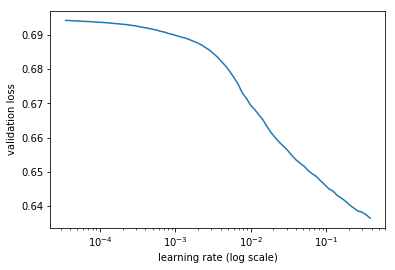

In [37]:
learn.lr_find()
learn.sched.plot()

In [38]:
lr = .1
# lr=.1
# wd=1e-7
# lrs = np.array([lr/100,lr/10,lr])/2

In [39]:
# learn.fit(lr,1, wds=wd, cycle_len=100,use_clr=(20,8))

learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.604107   0.6021     0.251331   0.000213  
    1      0.60017    0.607771   0.251351   1e-06            
    2      0.599478   0.599626   0.251351   1e-06            
    3      0.599193   0.748371   0.251349   4.6e-05          


[array([0.74837]), 0.2513488246543067, 4.561850169946675e-05]

 83%|████████▎ | 91/110 [00:16<00:03,  5.56it/s, loss=2.26] 

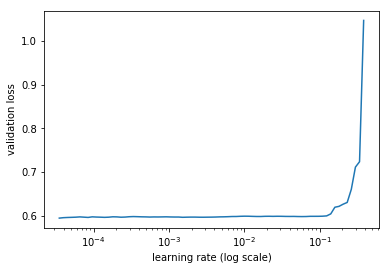

In [40]:
learn.lr_find()
learn.sched.plot()

In [41]:
learn.fit(lr,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   mask_acc   dice             
    0      0.601726   1.021432   0.251192   0.001411  
    1      0.600414   0.599462   0.251351   0.0              
    2      0.599287   0.597578   0.251351   0.0              
    3      0.598416   0.594296   0.251351   0.0              


[array([0.5943]), 0.2513510480778558, 0.0]

In [42]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


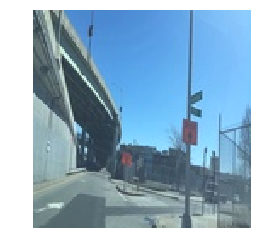

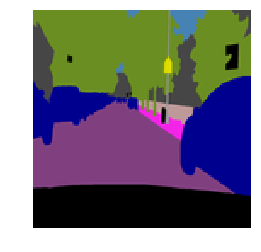

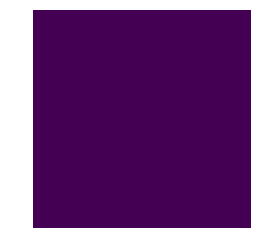

In [43]:
show_img((x[3,:].transpose(0,2).transpose(0,1)+2.5)/5)
show_img(y[3])
show_img(py[3][0]>0);